In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy import special
from tensorflow.keras import layers
import itertools
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
M = 16
k = int(np.log2(M))
n = 1
TRAINING_SNR = 7
BINARY_INP = True
rayleigh = False

In [3]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(k/n)*ebno) 
    return noise_std

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [4]:
# From https://colab.research.google.com/github/google-research/google-research/blob/master/vbmi/vbmi_demo.ipynb#scrollTo=LwSIGeXlD11E
# concatenated critic

class NN_function(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NN_function, self).__init__()
        self._f = tf.keras.Sequential(
          [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
          [tf.keras.layers.Dense(1)])

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

In [5]:
critic_params = {
    'layers': 2,
    'hidden_dim': 256,
    'activation': 'relu',
}

def MINE(scores):  
    def marg(x):
        batch_size = x.shape[0]
        marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
        return marg_*((batch_size*batch_size)/(batch_size*(batch_size-1.)))
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - tf.math.log(marg_term)

In [6]:
noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

def sample_Rayleigh_channel(x, noise_std):
    h_sample = (1/np.sqrt(2))*tf.sqrt(tf.random.normal(tf.shape(x))**2+tf.random.normal(tf.shape(x))**2)
    z_sample = tf.random.normal(tf.shape(x), stddev = noise_std)
    y_sample = x + tf.divide(z_sample,h_sample)
    return tf.cast(y_sample, tf.float32)

rayleigh_channel_layer = keras.layers.Lambda(lambda x: sample_Rayleigh_channel(x,noise_std))

if rayleigh:
    channel = keras.models.Sequential([rayleigh_channel_layer])
else:
    channel = keras.models.Sequential([channel_layer])

if BINARY_INP:
    encoder = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[k]),
            keras.layers.Dense(2*k, activation="elu"),
            keras.layers.Dense(2*k, activation="elu"),
            keras.layers.Dense(2*n, activation=None),
            shape_layer,
            norm_layer])
    
    decoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(2*k , activation="elu"),
                keras.layers.Dense(2*k, activation="elu"),
                keras.layers.Dense(k, activation='sigmoid')
                ])
else:
    encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2*n, activation=None),
            shape_layer,
            norm_layer])
    
    decoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])

autoencoder = keras.models.Sequential([encoder, channel, decoder])

In [7]:
def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    batch_size = input_msg.shape[0]
    if BINARY_INP:
        pred_error = tf.not_equal(input_msg, tf.round(msg))
        pred_error_msg = tf.reduce_max(tf.cast(pred_error, tf.float32), axis=1)
        bber = tf.reduce_mean(pred_error_msg)
    else:
        pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1,batch_size)), tf.argmax(msg, 1))
        bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [8]:
def random_sample(batch_size=32, k=4):
    if BINARY_INP:
        msg = np.random.randint(2, size=(batch_size,k))
    else:
        msg = np.random.randint(M, size=(batch_size,1))
    return msg

In [9]:
def test_encoding(M=16, n=1):
    if BINARY_INP:
        inp = np.array([list(i) for i in itertools.product([0, 1], repeat=int(np.log2(M)))])
    else:
        inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [10]:
def test_noisy_codeword(data):
    rcvd_word = data[1:2000]
    fig = plt.figure(figsize=(4,4))
    plt.plot(rcvd_word[:,0], rcvd_word[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [11]:
if BINARY_INP:
    loss_fn = tf.keras.losses.BinaryCrossentropy()
else:
    loss_fn = keras.losses.SparseCategoricalCrossentropy()
    
mean_loss = keras.metrics.Mean()

In [12]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [13]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))

In [14]:
def train_mi(NN_estimation, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
    optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch = random_sample(batch_size, k)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_recv = channel(x_enc)
                x = tf.reshape(x_enc, shape=[batch_size,2*n])
                y = tf.reshape(y_recv, shape=[batch_size,2*n])
                score = NN_estimation(x,y)
                loss = -MINE(score)
                gradients = tape.gradient(loss, NN_estimation.trainable_variables) 
                optimizer_mi.apply_gradients(zip(gradients, NN_estimation.trainable_variables))
            mi_avg = -mean_loss(loss)
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
        mean_loss.reset_states()

In [15]:
def train_decoder(n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size, k)
            with tf.GradientTape() as tape:
                y_pred = autoencoder(X_batch, training=True)
                loss = tf.reduce_mean(loss_fn(X_batch, y_pred))
                gradients = tape.gradient(loss, decoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, decoder.trainable_variables)) 
            mean_loss(loss)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred) 
        mean_loss.reset_states()

In [16]:
def train_encoder(NN_estimation, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
    optimizer_mi = keras.optimizers.Nadam(lr=0.005)
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size, k)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                y_recv = tf.grad_pass_through(channel)(x_enc) #forward pass:channel; backward pass Identity
                x = tf.reshape(x_enc, shape=[batch_size,2*n])
                y = tf.reshape(y_recv, shape=[batch_size,2*n])
                score = NN_estimation(x,y)
                loss = -MINE(score)
                gradients = tape.gradient(loss, encoder.trainable_variables) 
                optimizer_ae.apply_gradients(zip(gradients, encoder.trainable_variables))
            mi_avg = -mean_loss(loss)
        with tf.GradientTape() as tape:
            X_batch  = random_sample(batch_size, k) 
            x_enc = encoder(X_batch, training=True)
            y_recv = channel(x_enc)
            x = tf.reshape(x_enc, shape=[batch_size,2*n])
            y = tf.reshape(y_recv, shape=[batch_size,2*n])
            score = NN_estimation(x,y)
            loss = -MINE(score)
            gradients = tape.gradient(loss, NN_estimation.trainable_variables) 
            optimizer_mi.apply_gradients(zip(gradients, NN_estimation.trainable_variables))
        print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))
       # test_encoding(M, 1)

In [17]:
def Test_AE():
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):
        for it in range(1,1000):
            noise_std = EbNo_to_noise(snr_range[db])
            X_batch  = random_sample(500, k)
            code_word = encoder(X_batch)
            if rayleigh:
                rcvd_word = sample_Rayleigh_channel(code_word, noise_std)
            else:
                rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
            dcoded_msg = decoder(rcvd_word)
            bber = B_Ber_m(X_batch, dcoded_msg)
            bber_avg = mean_loss(bber)
        bber_vec[db] = bber_avg
        mean_loss.reset_states()
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

Training in Epoch 1/1
Epoch: 1, Mi is 1.9063373804092407
Training Bob in Epoch 1/5
Epoch: 1, Mi is 2.430373430252075
Training Bob in Epoch 2/5
Epoch: 2, Mi is 2.4276349544525146
Training Bob in Epoch 3/5
Epoch: 3, Mi is 2.4402523040771484
Training Bob in Epoch 4/5
Epoch: 4, Mi is 2.4549336433410645
Training Bob in Epoch 5/5
Epoch: 5, Mi is 2.471193313598633


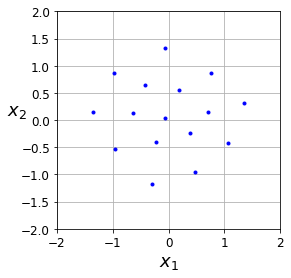

Training Bob in Epoch 1/5
Epoch: 1, Mi is 2.4762895107269287
Training Bob in Epoch 2/5
Epoch: 2, Mi is 2.485874652862549
Training Bob in Epoch 3/5
Epoch: 3, Mi is 2.4936628341674805
Training Bob in Epoch 4/5
Epoch: 4, Mi is 2.498422622680664
Training Bob in Epoch 5/5
Epoch: 5, Mi is 2.5010550022125244


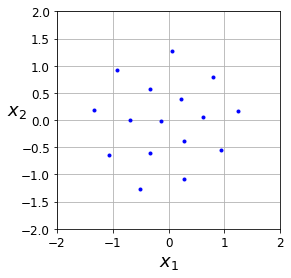

Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -2.49318, Batch_BER: 0.74200
Iteration: 20, Epoch: 1, Loss: -2.48567, Batch_BER: 0.72200
Iteration: 30, Epoch: 1, Loss: -2.47842, Batch_BER: 0.56000
Iteration: 40, Epoch: 1, Loss: -2.47131, Batch_BER: 0.48200
Iteration: 50, Epoch: 1, Loss: -2.46423, Batch_BER: 0.52800
Iteration: 60, Epoch: 1, Loss: -2.45720, Batch_BER: 0.52800
Iteration: 70, Epoch: 1, Loss: -2.45020, Batch_BER: 0.54000
Iteration: 80, Epoch: 1, Loss: -2.44325, Batch_BER: 0.51600
Iteration: 90, Epoch: 1, Loss: -2.43634, Batch_BER: 0.52600
Iteration: 100, Epoch: 1, Loss: -2.42948, Batch_BER: 0.53200
Iteration: 110, Epoch: 1, Loss: -2.42266, Batch_BER: 0.50000
Iteration: 120, Epoch: 1, Loss: -2.41589, Batch_BER: 0.51600
Iteration: 130, Epoch: 1, Loss: -2.40915, Batch_BER: 0.53400
Iteration: 140, Epoch: 1, Loss: -2.40245, Batch_BER: 0.48600
Iteration: 150, Epoch: 1, Loss: -2.39579, Batch_BER: 0.49600
Iteration: 160, Epoch: 1, Loss: -2.38917, Batch_BER: 0.51400
Iterati

Iteration: 130, Epoch: 4, Loss: 0.12953, Batch_BER: 0.12200
Iteration: 140, Epoch: 4, Loss: 0.12920, Batch_BER: 0.12000
Iteration: 150, Epoch: 4, Loss: 0.12938, Batch_BER: 0.13800
Iteration: 160, Epoch: 4, Loss: 0.12901, Batch_BER: 0.12800
Iteration: 170, Epoch: 4, Loss: 0.12933, Batch_BER: 0.15200
Iteration: 180, Epoch: 4, Loss: 0.12998, Batch_BER: 0.14200
Iteration: 190, Epoch: 4, Loss: 0.13016, Batch_BER: 0.15400
Iteration: 200, Epoch: 4, Loss: 0.13032, Batch_BER: 0.11600
Iteration: 210, Epoch: 4, Loss: 0.13049, Batch_BER: 0.13600
Iteration: 220, Epoch: 4, Loss: 0.13028, Batch_BER: 0.11000
Iteration: 230, Epoch: 4, Loss: 0.13011, Batch_BER: 0.15400
Iteration: 240, Epoch: 4, Loss: 0.13012, Batch_BER: 0.10600
Iteration: 250, Epoch: 4, Loss: 0.13005, Batch_BER: 0.13200
Iteration: 260, Epoch: 4, Loss: 0.12997, Batch_BER: 0.13800
Iteration: 270, Epoch: 4, Loss: 0.12997, Batch_BER: 0.11200
Iteration: 280, Epoch: 4, Loss: 0.12999, Batch_BER: 0.12600
Iteration: 290, Epoch: 4, Loss: 0.12997,

Iteration: 270, Epoch: 2, Loss: 0.11481, Batch_BER: 0.07400
Iteration: 280, Epoch: 2, Loss: 0.11479, Batch_BER: 0.11800
Iteration: 290, Epoch: 2, Loss: 0.11463, Batch_BER: 0.09200
Iteration: 300, Epoch: 2, Loss: 0.11475, Batch_BER: 0.08000
Iteration: 310, Epoch: 2, Loss: 0.11477, Batch_BER: 0.12600
Iteration: 320, Epoch: 2, Loss: 0.11512, Batch_BER: 0.12200
Iteration: 330, Epoch: 2, Loss: 0.11495, Batch_BER: 0.08000
Iteration: 340, Epoch: 2, Loss: 0.11494, Batch_BER: 0.11000
Iteration: 350, Epoch: 2, Loss: 0.11524, Batch_BER: 0.12400
Iteration: 360, Epoch: 2, Loss: 0.11511, Batch_BER: 0.08600
Iteration: 370, Epoch: 2, Loss: 0.11504, Batch_BER: 0.10400
Iteration: 380, Epoch: 2, Loss: 0.11502, Batch_BER: 0.11200
Iteration: 390, Epoch: 2, Loss: 0.11474, Batch_BER: 0.11800
Iteration: 400, Epoch: 2, Loss: 0.11476, Batch_BER: 0.10000
Interim result for Epoch: 2, Loss: 0.11476, Batch_BER: 0.10000
Training Bob in Epoch 3/4
Iteration: 10, Epoch: 3, Loss: 0.10982, Batch_BER: 0.09400
Iteration: 2

Iteration: 400, Epoch: 1, Loss: 0.10965, Batch_BER: 0.09800
Iteration: 410, Epoch: 1, Loss: 0.10951, Batch_BER: 0.09800
Iteration: 420, Epoch: 1, Loss: 0.10949, Batch_BER: 0.10400
Iteration: 430, Epoch: 1, Loss: 0.10941, Batch_BER: 0.08200
Iteration: 440, Epoch: 1, Loss: 0.10931, Batch_BER: 0.07800
Iteration: 450, Epoch: 1, Loss: 0.10939, Batch_BER: 0.11000
Iteration: 460, Epoch: 1, Loss: 0.10936, Batch_BER: 0.12200
Iteration: 470, Epoch: 1, Loss: 0.10927, Batch_BER: 0.10000
Iteration: 480, Epoch: 1, Loss: 0.10921, Batch_BER: 0.12000
Iteration: 490, Epoch: 1, Loss: 0.10924, Batch_BER: 0.10600
Iteration: 500, Epoch: 1, Loss: 0.10922, Batch_BER: 0.08800
Interim result for Epoch: 1, Loss: 0.10922, Batch_BER: 0.08800


In [18]:
score_fn = NN_function(**critic_params)
train_mi(score_fn, n_epochs=1, n_steps=500, batch_size=64)
train_encoder(score_fn, n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.005)
test_encoding(M, 1)
train_encoder(score_fn, n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.001)
test_encoding(M, 1)
train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.015, plot_encoding=False)
train_decoder(n_epochs=4, n_steps=400, batch_size=500, learning_rate=0.01, plot_encoding=False)
train_decoder(n_epochs=1, n_steps=500, batch_size=500, learning_rate=0.005, plot_encoding=False)

In [19]:
bber_data = Test_AE()

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


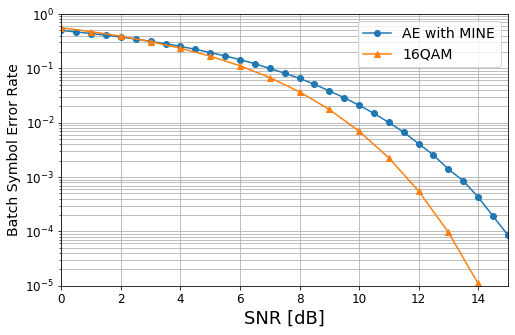

In [20]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebnodb):
    ebno = 10.**(ebnodb/10)
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*ebno))

def QAM_pb(ebnodb):
    ebno = 10.**(ebnodb/10)
    return (4/np.log2(M))*special.erfc(np.sqrt((3*ebno*np.log2(M))/(M-1)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data[0], bber_data[1], 'o-')

plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with MINE', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")